# Compressing Data Via Dimensionality Reduction


An alternative approach for dimensionality reduction is **feature extraction**. 

## Unsupervised Dimensionality Reduction Via Principal Component Analysis (PCA)

The difference between feature selection and feature extraction is that while we maintain the orignal features when we use feature selection algorithms, such as Sequential Backward Selection, we use feature extraction to transform or project the data onto a new feature space.

In the context of dimensionality reduction, feature extraction can be understood as an approach to data compression with the goal of maintaining most of the relevant information. In practice, feature extraction is not only used to improve storage space or the computational efficiency of the learning algorithm but can also improve the predictive performance by reducing the **curse of dimensionality**, especially if we are working with non regularized models.

### The Main Steps In Principal Component Analysis (PCA)

PCA: Unsupervised linear transformation technique that is widely used across different fields, most prominently used for feature extraction and dimensionality reduction. It helps us identify patterns in data based on the correlation between features. 

In a nutshell, PCA aims to find the directions of maximum variance in high-dimensional data and projects the data onto a new subspace with equal or fewer dimentions than the original one. 

As a result of transforming the original d-dimensional data onto a new k-dimensional subspace, the first principal component will have the largest possible variance. All consquent principal components will have the largest variance given the constraint that these components are uncorrelated (orthogonal) to the other principal components - even if the input features are correlated, the resulting principal components will be mutually orthogonal. 

Note that the PCA directions are highly sensitive to data scaling, and we need to standarize the features prior to PCA if the features wer emeasured in different scales and we want to assign equal importance to all features.

Before looking at the PCA algorithm for dimensionality reduction in more detail, let’s summarize the approach in a few simple steps:
1. Standardize the d-dimensional dataset.
2. Construct the covariance matrix.
3. Decompose the covariance matrix into its eigenvectors and eigenvalues.
4. Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors.
5. Select k eigenvectors, which correspond to the k largest eigenvalues, where k is the dimensionality of the new feature subspace (k =< d).
6. Construct a projection matrix, W, from the “top” k eigenvectors.
7. Transform the d-dimensional input dataset, X, using the projection matrix, W, to obtain the
new k-dimensional feature subspace.

### Extracting the Principal Components Step By Step

In this subsection, we will tackle the first four steps of a PCA:
1. Standardizing the data
2. Constructing the covariance matrix
3. Obtaining the eigenvalues and eigenvectors of the covariance matrix
4. Sorting the eigenvalues by decreasing order to rank the eigenvectors

In [4]:
import pandas as pd
df_wine = pd.read_csv(
            'https://archive.ics.uci.edu/ml/'
            'machine-learning-databases/wine/wine.data',
            header=None
            )

In [7]:
df_wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [6]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y,
                                                    random_state=0)


# standardize the features
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

Then we calculate the covariance matrix. The symmetric dxd dimensional covariance matrix, where d is the number of dimensions in the dataset, stores the pairwise covariances between the different features. Note that the sample means are zero if we standarized the dataset. A positive covariance indicates that the features vary in opposite directions. 

The eigenvectors of the covariance matrix represent the principal components (the direction of maximum variance), whereas the corresponding eigenvalues will define their magnitude. In the case of the wine dataset, we would obtain 13 eigenvectors and eigenvalues from the 13x13 dimensional covariance matrix.

In [9]:
import numpy as np

cov_mat = np.cov(X_train_std.T) # covariance matrix

eigen_vals, eigen_vecs = np.linalg.eig(cov_mat) # eigenvalues and eigenvectors

print('\nEigenvalues \n', eigen_vals)


Eigenvalues 
 [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


### Total And Explained Variance

Since we want to reduce the dimensionality of our dataset by compressing it onto a new feature subspace, we only select the subset of eigenvectors (principal components) that contains most of the information (variance). The eigenvalues define the magnitude of the eigenvectors, so we have to sort the eigenvalues by decreasing magnitude; we are interested in the top k eigenvectors based on the values of their corresponding eigenvalues. 

But before we collect those k most informative eigenvectors, let’s plot the variance explained ratios of the eigenvalues. The variance explained ratio of an eigenvalue is simply the fraction of an eigenvalue, and the total sum of the eigenvalues

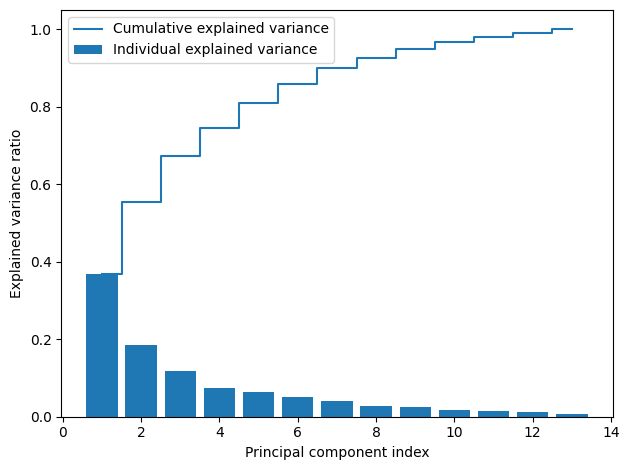

In [10]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in
    sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt

plt.bar(range(1,14), var_exp, align='center',
        label='Individual explained variance')
plt.step(range(1,14), cum_var_exp, where='mid',
        label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Feature Transformation

The remaining steps we are going to tackle in this section are the following:
1. Select k eigenvectors, which correspond to the k largest eigenvalues, where k is the dimensionality of the new feature subspace (k < d).
2. Construct a projection matrix, W, from the “top” k eigenvectors.
3. Transform the d-dimensional input dataset, X, using the projection matrix, W, to obtain the
new k-dimensional feature subspace.

Or, in less technical terms, we will sort the eigenpairs by descending orer of the eigenvalues, construct a projection matrix from the selected eigenvectors, and use the projection matrix to transform the data onto the lower-dimensional subspace,

In [11]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [12]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [13]:
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

In [14]:
X_train_pca = X_train_std.dot(w)

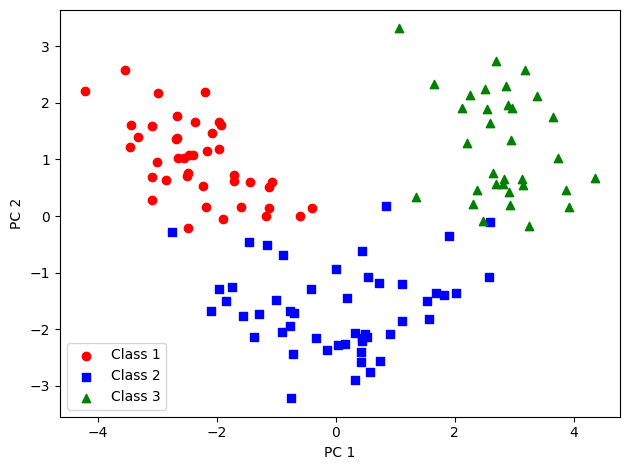

In [15]:
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], X_train_pca[y_train==l, 1],
                c=c, label=f'Class {l}', marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

### Principal Component Analysis in Scikit-Learn

In [16]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                            np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')

/home/nathalie/Desktop/projects/ml-book/ml-book/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


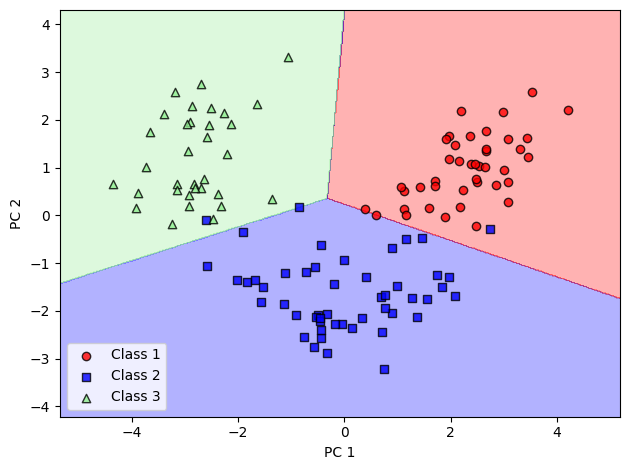

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# initializing the PCA transformer and logistic regression estimator:
pca = PCA(n_components=2)
lr = LogisticRegression(multi_class='ovr',
                        random_state=1,
                        solver='lbfgs')

# dimensionality reduction:
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# fitting the logistic regression model on the reduced dataset:
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [18]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

### Assesing Feature Contributions

The contributions of each original feature to a given principal component are often called **loadings**. 

The factor loadings can be computed by scaling the eigenvectors by the square root of the eigenvalues. The resulting values can then be interpreted as the correlation between the orignal features and the principal component.

First, we compute the 13×13-dimensional loadings matrix by multiplying the eigenvectors by the
square root of the eigenvalues:

In [19]:
loadings = eigen_vecs * np.sqrt(eigen_vals)

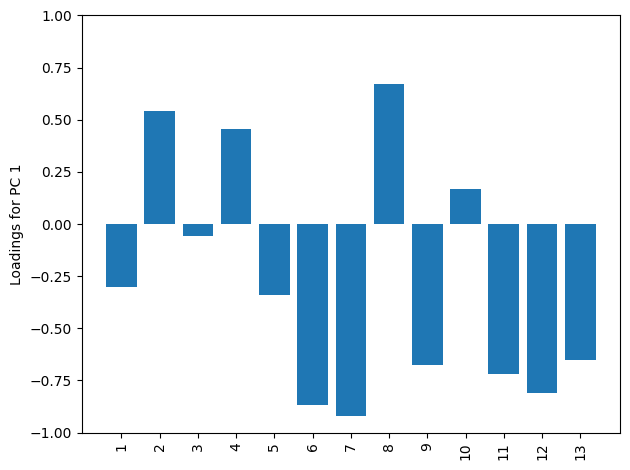

In [20]:
fig, ax = plt.subplots()
ax.bar(range(13), loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

In [21]:
sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

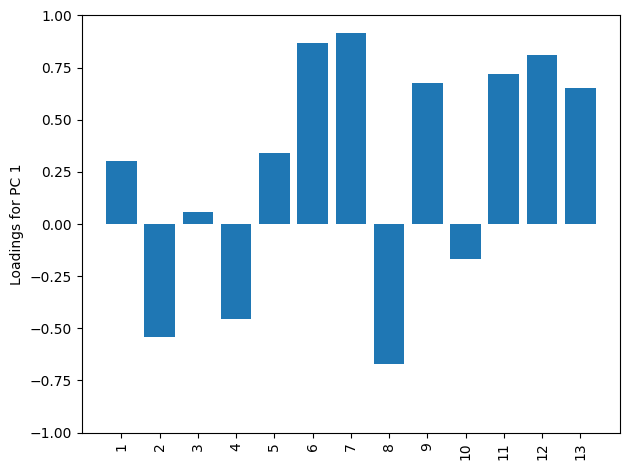

In [22]:
fig, ax = plt.subplots()
ax.bar(range(13), sklearn_loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

## Supervised Data Compression Via Linear Discriminant Analysis (LDA)

LDA can be used as a technique for feature extraction to increase computational efficiency and reduce the degree of overfitting due to the curse of dimensionality in non-regularized models.

The general concept of LDA is similar to PCA, but whereas PCA attemps to find the orthogonal component axes of maximum variance in dataset, the goal in LDA is to find the feature subspace that optimizes class separability 

### PCA vs LDA

Both are *linear transformation techniques* that can be used to reduce the number of dimensions in a dataset; the former is an unsupervised algorithm, whereas the latter is supervised.

![Alt text](../images/16.png)

A linear discriminant, as shown on the x axis (LD1), would separate the two normal distributed classes well. Although the exemplary linear discriminant shown on the y axis (LD2) captures a lot of the variance in the dataset, it would fail as a good linear discriminant since it does not capture any of the class discriminatory information.

One assumption in LDA is that hte data is normally distributed. Also, we assume that the classes have identical covariance matrices and that the training examples are statistically independent of each other.

| **Aspect**                  | **Principal Component Analysis (PCA)**                               | **Linear Discriminant Analysis (LDA)**                              |
|-----------------------------|----------------------------------------------------------------------|----------------------------------------------------------------------|
| **Purpose**                 | Reduces dimensionality by finding directions of maximum variance.   | Reduces dimensionality while preserving class separability.         |
| **Supervised/Unsupervised** | Unsupervised. Does not use class labels.                            | Supervised. Requires class labels.                                  |
| **Optimization Goal**       | Maximizes the variance of the data along principal components.       | Maximizes the separation between multiple classes.                  |
| **Key Output**              | Principal components (orthogonal axes capturing variance).           | Linear discriminants (axes that best separate classes).             |
| **Feature Use**             | Uses all features to find principal components.                     | Uses class information to find discriminant axes.                   |
| **When to Use**             | When the goal is to compress data or explore variance structure.     | When the goal is classification or class separation.                |
| **Dimensionality Limit**    | Can extract up to the number of original features.                  | Can extract up to (number of classes - 1) discriminants.            |
| **Variance Explanation**    | Explains variance within the entire dataset.                        | Does not aim to explain variance but rather to maximize separability.|
| **Class Information**       | Ignores class labels.                                               | Uses class labels to compute discriminants.                         |
| **Example Applications**    | Image compression, exploratory data analysis.                       | Face recognition, classification tasks.                             |


### The Inner Workings Of Linear Discriminant Analysis

Before we dive into the code implementation, let’s briefly summarize the main steps that are required to perform LDA:
1. Standardize the d-dimensional dataset (d is the number of features).
2. For each class, compute the d-dimensional mean vector.
3. Construct the between-class scatter matrix, SB, and the within-class scatter matrix, SW.
4. Compute the eigenvectors and corresponding eigenvalues of the matrix, 𝑺𝑺𝑊𝑊
−1𝑺𝑺𝐵𝐵.
5. Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors.
6. Choose the k eigenvectors that correspond to the k largest eigenvalues to construct a d×k-dimensional transformation matrix, W; the eigenvectors are the columns of this matrix.
7. Project the examples onto the new feature subspace using the transformation matrix, W.

As we can see, LDA is quite similar to PCA in the sense that we are decomposing matrices into eigenvalues and eigenvectors, which will form the new lower-dimensional feature space. However, as mentioned before, LDA takes class label information into account, which is represented in the form of the mean vectors computed in step 2.

### Computing the Scatter Matrices

In [23]:
# First: Compute the mean vectors

np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1,4):
    mean_vecs.append(np.mean(
                X_train_std[y_train==label], axis=0))
    print(f'MV {label}: {mean_vecs[label - 1]}\n')

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



In [24]:
# Within-class scatter matrix

d = 13 # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter

print('Within-class scatter matrix: '
f'{S_W.shape[0]}x{S_W.shape[1]}')

Within-class scatter matrix: 13x13


In [25]:
print('Class label distribution:', np.bincount(y_train)[1:])

Class label distribution: [41 50 33]


In [26]:
d = 13 # number of features
S_W = np.zeros((d, d))
for label,mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter

print('Scaled within-class scatter matrix: 'f'{S_W.shape[0]}x{S_W.shape[1]}')

Scaled within-class scatter matrix: 13x13


In [27]:
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)

d = 13 # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1) # make column vector
    S_B += n * (mean_vec - mean_overall).dot(
    (mean_vec - mean_overall).T)

print('Between-class scatter matrix: 'f'{S_B.shape[0]}x{S_B.shape[1]}')

Between-class scatter matrix: 13x13


### Selecting Linear Discriminants For The New Feature Subspace

In [28]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [29]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]

In [30]:
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

349.61780890599397
172.7615221897938
3.277875948160424e-14
2.842170943040401e-14
2.6347620763320822e-14
2.6347620763320822e-14
1.7169492680170306e-14
1.7169492680170306e-14
1.674335053365992e-14
1.2740060380615543e-14
7.458378098449665e-15
4.737048557054326e-15
3.688843187314971e-15


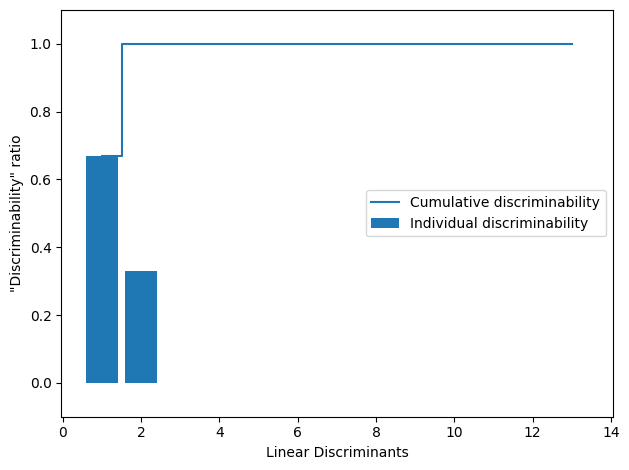

In [31]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]

cum_discr = np.cumsum(discr)
plt.bar(range(1, 14), discr, align='center',
        label='Individual discriminability')

plt.step(range(1, 14), cum_discr, where='mid',
        label='Cumulative discriminability')
plt.ylabel('"Discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [32]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


### Projecting Examples Onto The New Feature Space

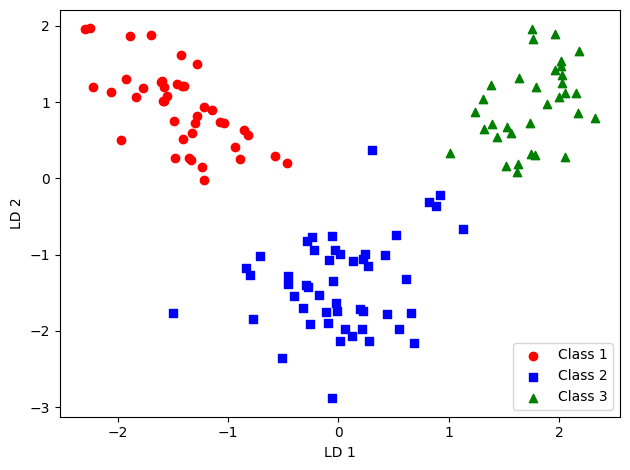

In [33]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0],
    X_train_lda[y_train==l, 1] * (-1),
    c=c, label= f'Class {l}', marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### LDA Via Scikit-Learn

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

/home/nathalie/Desktop/projects/ml-book/ml-book/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


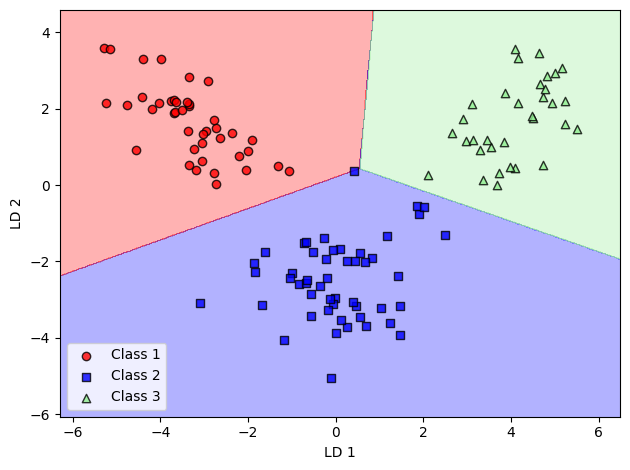

In [35]:
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

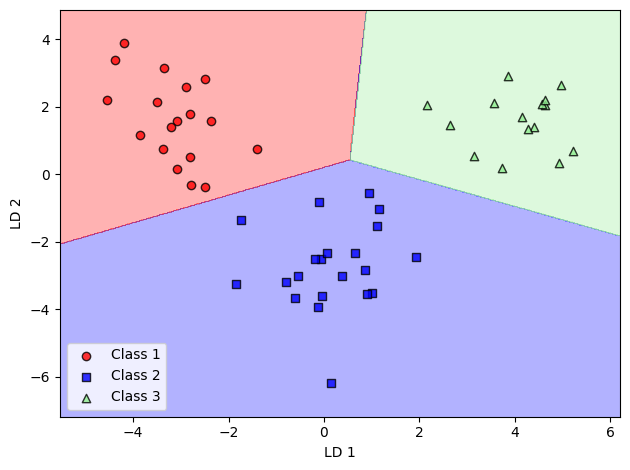

In [36]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## NonLinear Dimensionality Reduction And Visualization

One nonlinear dimensionality reuction technique that is particularly worth highlighting is **t-distributed stochastic neighbor embedding (t-SNE)**since it is frequently used in literature to visualize high-dimensional datasets in two or three dimensions. 

![Alt text](../images/17.png)

### Why Consider Nonlinear Dimensionality Reduction?

Many linear ml algorithms make assumptions about the linear separability of the input data. 

The development and application of nonlinear dimensinality reduction techniques is also often referred to as manifold learning, where a manifold refers to a lower dimensional topological space embedded in a high dimensional space. Algorithms for manifold learning have to capture the complicated structure of the data in order to project it onto a lower dimensional space where the relationship between data points is preserved. 

### Visualizing Data Via t-Distributed Stochastic Neighbor Embedding

In a nutshell, t-SNE is modeling data points based on their pair-wise distances in the high dimensional (original) feature space. Then, it finds a probability distribution of pair-wise distances in the new, lower-dimensional space that is close to the probability distribution of pair-wise distances in the original space.
In other words, t-SNE learns to embed data points into lower dimensinal space such that the pair-wise distances in the original space are preserved.

The following code shows a quick demonstration of how t-SNE can be applied to a 64-dimensional dataset:

In [37]:
from sklearn.datasets import load_digits

digits = load_digits()

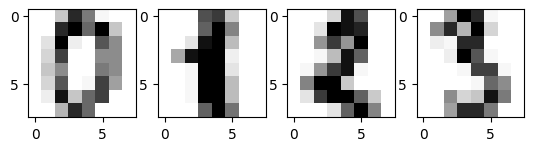

In [38]:
fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(digits.images[i], cmap='Greys')
plt.show()

In [39]:
digits.data.shape

(1797, 64)

In [40]:
y_digits = digits.target
X_digits = digits.data

In [41]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=123)
X_digits_tsne = tsne.fit_transform(X_digits)

In [42]:
import matplotlib.patheffects as PathEffects
def plot_projection(x, colors):
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')

    for i in range(10):
        plt.scatter(x[colors == i, 0], x[colors == i, 1])
    
    for i in range(10):
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
        PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])

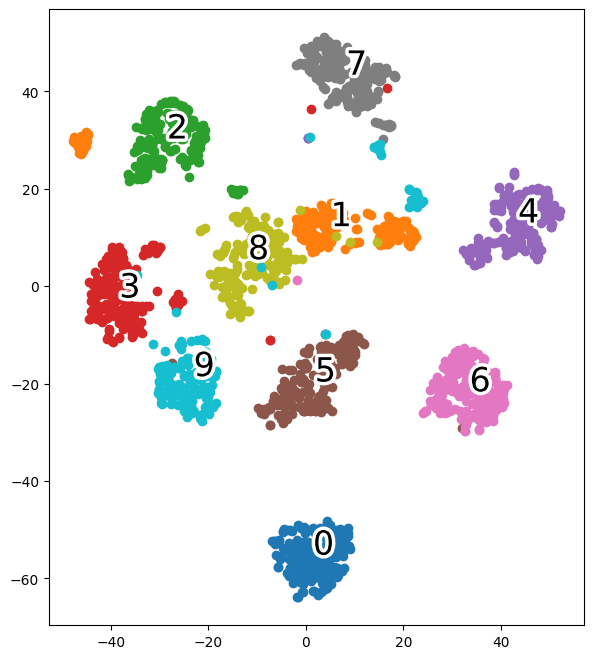

In [43]:
plot_projection(X_digits_tsne, y_digits)
plt.show()